In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adamax

C:\Users\SHWETA BISHT\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
Normal = [r'C:\Users\SHWETA BISHT\Desktop\stroke images\Brain_Data_Organised\Normal']

Stroke= [r'C:\Users\SHWETA BISHT\Desktop\stroke images\Brain_Data_Organised\Stroke']

file_p = []
labels = []
dict_lists = [Normal, Stroke]
class_labels = ['Normal', 'Stroke']

for i, dir_list in enumerate(dict_lists):
     for j in dir_list:
            list_f = os.listdir(j)
            for name in list_f:
                fpath = os.path.join(j, name)
                file_p.append(fpath)
                labels.append(class_labels[i])


failpath = pd.Series(file_p, name="filepaths")
Labelss = pd.Series(labels, name="labels")
data = pd.concat([failpath, Labelss], axis=1)
df = pd.DataFrame(data)

In [7]:
df.head()

,filepaths,labels
0,C:\Users\SHWETA BISHT\Desktop\stroke images\Br...,Normal
1,C:\Users\SHWETA BISHT\Desktop\stroke images\Br...,Normal
2,C:\Users\SHWETA BISHT\Desktop\stroke images\Br...,Normal
3,C:\Users\SHWETA BISHT\Desktop\stroke images\Br...,Normal
4,C:\Users\SHWETA BISHT\Desktop\stroke images\Br...,Normal


In [8]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42,stratify=df.labels)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42,stratify=train_df.labels)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(1332, 2)
(523, 2)
(236, 2)


In [9]:
def enhance_image(image):
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    hue = image[:, :, 0]
    saturation = image[:, :, 1]
    value = image[:, :, 2]
    value = np.clip(value * 1.25, 0, 255)

    image[:, :, 2] = value

    return image

In [10]:
image_gen = ImageDataGenerator(
    rescale=1./255,#Normalisation process
    preprocessing_function=lambda image: enhance_image(image))
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(256,256),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=64,
                                      shuffle=False            
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                     target_size=(256,256),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=64,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_df,x_col="filepaths", y_col="labels",
                                    target_size=(256,256),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=64,
                                    shuffle=False
                                   )

Found 1332 validated image filenames belonging to 2 classes.
Found 523 validated image filenames belonging to 2 classes.
Found 236 validated image filenames belonging to 2 classes.


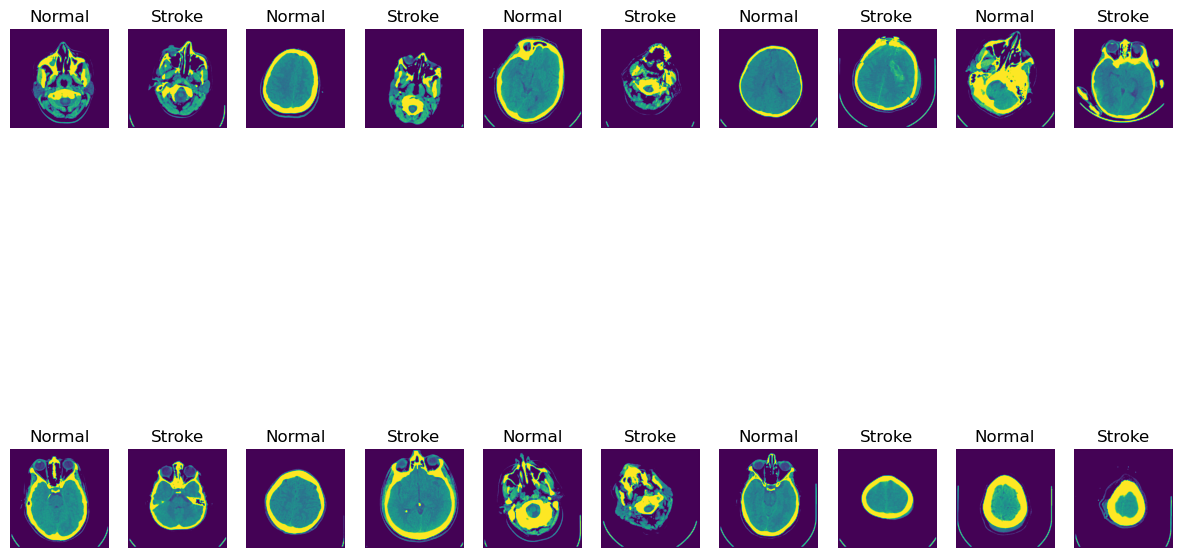

In [11]:
import matplotlib.pyplot as plt

# Define the number of images to display from each class
num_images_per_class = 10

# Get class labels
class_labels = list(train.class_indices.keys())

# Plot images from each class
plt.figure(figsize=(15, 10))
for label in class_labels:
    # Get indices of images belonging to the current class
    indices = train_df[train_df['labels'] == label].index
    
    # Randomly sample a subset of indices if there are more than the desired number of images per class
    indices = np.random.choice(indices, min(num_images_per_class, len(indices)), replace=False)
    
    # Plot images
    for i, idx in enumerate(indices):
        plt.subplot(len(class_labels), num_images_per_class, len(class_labels)*i + class_labels.index(label) + 1)
        plt.imshow(plt.imread(train_df.loc[idx, 'filepaths']))  # Load and plot the image
        plt.title(label)
        plt.axis('off')
plt.show()

In [12]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Define the number of output classes
num_classes = 2  # Example: If you have 2 classes (e.g., Normal and Stroke)

# Load VGG19 model with pre-trained weights and without top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add custom dense layers on top of VGG19
x = base_model.output
x = Flatten()(x) 
x = Dense(64, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

# Create model with base VGG19 layers frozen and custom dense layers trainable
model_unfreeze = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_unfreeze.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_unfreeze.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 34s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           13

 Total params: 22,121,730 (84.39 MB)

 Trainable params: 22,121,730 (84.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Assuming you have already loaded the train, val, and test data generators

# Train the model
history = model_unfreeze.fit(train, epochs=50, validation_data=val)

# Evaluate the model on test data
loss, accuracy = model_unfreeze.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/50


C:\Users\SHWETA BISHT\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 3005s 141s/step - accuracy: 0.5358 - loss: 61.4256 - val_accuracy: 0.6695 - val_loss: 0.6375
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2913s 138s/step - accuracy: 0.6403 - loss: 0.7253 - val_accuracy: 0.6695 - val_loss: 0.6318
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4040s 196s/step - accuracy: 0.6721 - loss: 0.6295 - val_accuracy: 0.6695 - val_loss: 0.6246
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2789s 133s/step - accuracy: 0.6617 - loss: 0.6199 - val_accuracy: 0.6695 - val_loss: 0.6399
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2851s 136s/step - accuracy: 0.6701 - loss: 0.6410 - val_accuracy: 0.6695 - val_loss: 0.6314
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2820s 135s/step - accuracy: 0.6638 - loss: 0.6393 - val_accuracy: 0.6695 - val_loss: 0.6425
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2720s 129s/step - accuracy: 0.6664 - loss: 0.6224 - val_accuracy: 0.6695 - val_loss: 0.6337
Epoch 8/50
14/21 ━━━━━━━━━━━━━━━━━━━━ 15:25 132s/step - accuracy: 0.6539 - loss: 0.6379

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
